# CSC 180 Final Project: Classifying Diabetes Risk Among Patient Questionnaires
### Spring 2021
Derek Sakasegawa (219500607)  
Eric Wong (219515297)  
Jack Tran(219589865)  
Dr. Chen  
5/3/21

## Data Preprocessing

In this section, we will be loading the data which is filled with answers to a questionnaire by numerous patients. The answers provided by each patient will be used for training in our AI models to predict whether or not each patient is at risk of diabetes or not. Listed below are some helper functions.

In [ ]:
import csv
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import tensorflow as tf
import time
from sklearn import preprocessing
from sklearn.exceptions import NotFittedError
from collections.abc import Sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC 
from sklearn import metrics

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)
    
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low
    
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

    
df = pd.read_csv("diabetes_data_upload.csv", na_values=['NA','?'])

df.columns = ['age','gender','polyuria', 'polydipsia', 'sudden_weight_loss', 'weakness', 'polyphagia', 'genital_thrush', 'visual_blurring', 'itching', 
              'irritability', 'delayed_healing', 'partial_paresis', 'muscle_stiffness', 'alopecia', 'obesity', 'class']

Here, we are showing off the data that is going to be used for training and testing in this project.

In [ ]:
df

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,Female,Yes,Yes,Yes,No,Yes,No,No,Yes,No,Yes,Yes,No,No,No,Positive
516,48,Female,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,Yes,No,No,No,Positive
517,58,Female,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,No,Yes,Positive
518,32,Female,No,No,No,Yes,No,No,Yes,Yes,No,Yes,No,No,Yes,No,Negative


We check here for any missing values in the dataset, so we can drop them if there are any. However, it appears there are none.

In [ ]:
df.isnull().sum()

age                   0
gender                0
polyuria              0
polydipsia            0
sudden_weight_loss    0
weakness              0
polyphagia            0
genital_thrush        0
visual_blurring       0
itching               0
irritability          0
delayed_healing       0
partial_paresis       0
muscle_stiffness      0
alopecia              0
obesity               0
class                 0
dtype: int64

## Encoding Categorical Features

Now we encode each categorical feature to a numeric value as part of our preprocessing of the data.

In [ ]:
encode_text_index(df, 'gender')
encode_text_index(df, 'polyuria')
encode_text_index(df, 'polydipsia')
encode_text_index(df, 'sudden_weight_loss')
encode_text_index(df, 'weakness')
encode_text_index(df, 'polyphagia')
encode_text_index(df, 'genital_thrush')
encode_text_index(df, 'visual_blurring')
encode_text_index(df, 'itching')
encode_text_index(df, 'irritability')
encode_text_index(df, 'delayed_healing')
encode_text_index(df, 'partial_paresis')
encode_text_index(df, 'muscle_stiffness')
encode_text_index(df, 'alopecia')
encode_text_index(df, 'obesity')
encode_text_index(df, 'class')

array(['Negative', 'Positive'], dtype=object)

Here, we display the dataframe again to show that all attributes that had categorical values have been label encoded properly.

In [ ]:
df

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1
517,58,0,1,1,1,1,1,0,1,0,0,0,1,1,0,1,1
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


Next, we will show roughly about how many patients in the dataset were classified as nondiabetic and diabetic. Note: Nondiabetic was encoded to a value of 0 and diabetic was encoded to a value of 1.

It can be seen that roughly 200 patients are classified as nondiabetic and 320 are classified as diabetic.

In [ ]:
df[df['class']== 0]

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
200,40,1,0,1,1,1,0,0,1,1,0,0,1,1,0,0,0
201,28,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
202,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
203,34,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
204,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,67,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0
511,66,1,0,0,0,1,1,0,1,1,0,1,1,1,1,0,0
512,43,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
518,32,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0


In [ ]:
df[df['class']== 1]

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,62,0,1,1,1,1,0,0,1,0,0,0,1,0,0,1,1
514,54,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,1
515,39,0,1,1,1,0,1,0,0,1,0,1,1,0,0,0,1
516,48,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1


## Splitting Data into Test and Training


Now we specify our inputs and outputs for the models and algorithms. Then they are split for training and testing.

In [ ]:
x = df.drop("class", axis=1)
y = df["class"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape

((416, 16), (416,))

##Random Forest Algorithm

In [ ]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
predictions_rf = rf_model.predict(x_test)

In [ ]:
score = accuracy_score(y_test, predictions_rf)
print("Final Accuracy for Random Forest: {}".format(score))

Final Accuracy for Random Forest: 0.9903846153846154


Here, we are testing if model's performance in predicting 20 patients' condition after implementing the Random Forest algorithm.

In [ ]:
df_rf = pd.DataFrame({"Predicted": predictions_rf , "Actual": y_test})
df_rf[0:20]

,Predicted,Actual
275,0,0
93,1,1
6,1,1
167,1,1
90,1,1
513,1,1
362,1,1
228,0,0
192,1,1
482,0,0


In [ ]:
cm2 = metrics.confusion_matrix(y_test, predictions_rf)
print(cm2)

[[33  0]
 [ 1 70]]


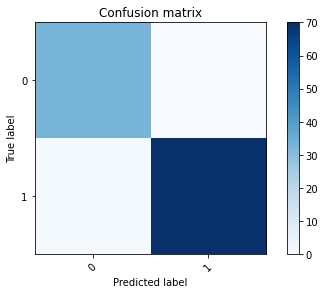

In [ ]:
classes = encode_text_index(df,"class")
plt.figure()
plot_confusion_matrix(cm2, classes)
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.99      0.99        71

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



##KNN Algorithm

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)

In [ ]:
model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
predictions_knn = model.predict(x_test)

In [ ]:
score1 = accuracy_score(y_test, predictions_knn)

In [ ]:
print("Final Accuracy for KNN: {}".format(score1))

Final Accuracy for KNN: 0.875


Here we are showing how well our model performed after implementing the KNN algorithm.

In [ ]:
df_knn = pd.DataFrame({"Predicted Values": predictions_knn , "Actual Values": y_test})
df_knn[40:60]

,Predicted Values,Actual Values
299,1,1
347,1,0
55,0,1
515,1,1
519,0,0
158,1,1
222,0,0
255,1,1
153,1,1
176,1,1


In [ ]:
cm = metrics.confusion_matrix(y_test, predictions_knn)
print(cm)

[[30  3]
 [10 61]]


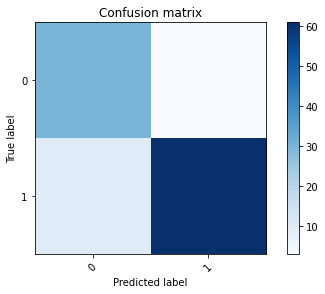

In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes)
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82        33
           1       0.95      0.86      0.90        71

    accuracy                           0.88       104
   macro avg       0.85      0.88      0.86       104
weighted avg       0.89      0.88      0.88       104



## SVM Algorithm

In [ ]:
model = SVC(kernel = "linear")

In [ ]:
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
predictions_svm = model.predict(x_test)

In [ ]:
score1 = accuracy_score(y_test, predictions_svm)

In [ ]:
print("Final Accuracy for SVM: {}".format(score1))

Final Accuracy for SVM: 0.8942307692307693


Here we show how well our model performed after implementing the SVM algorithm.

In [ ]:
df_svm = pd.DataFrame({"Predicted Values": predictions_svm , "Actual Values": y_test})
df_svm[90:110]

,Predicted Values,Actual Values
314,0,0
448,1,1
365,1,1
177,1,1
286,0,0
346,1,1
131,1,1
433,1,1
456,1,1
69,1,1


In [ ]:
cm = metrics.confusion_matrix(y_test, predictions_svm)
print(cm)

[[28  5]
 [ 6 65]]


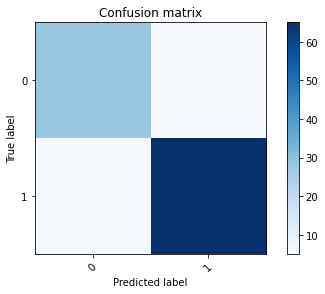

In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes)
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions_svm))

              precision    recall  f1-score   support

           0       0.82      0.85      0.84        33
           1       0.93      0.92      0.92        71

    accuracy                           0.89       104
   macro avg       0.88      0.88      0.88       104
weighted avg       0.90      0.89      0.89       104



##Fully Connected Neural Networks

Now we split and train the data again for the building of our fully connected neural network models.

In [ ]:
x, y = to_xy(df, 'class')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, y_train.shape

((416, 16), (416, 2))

## Fully Connected Neural Network Model #1 (Using relu & adam)

In [ ]:
model = Sequential()

#Activation1
model.add(Dense(10, input_dim=x.shape[1], activation='relu')) # Hidden 1     
model.add(Dense(10, activation='relu')) # Hidden 2
model.add(Dense(10)) 
model.add(Dense(10))
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 4.8505 - val_loss: 1.0240
Epoch 2/1000
13/13 - 0s - loss: 1.1889 - val_loss: 1.0835
Epoch 3/1000
13/13 - 0s - loss: 0.9517 - val_loss: 1.0715
Epoch 4/1000
13/13 - 0s - loss: 0.8998 - val_loss: 0.9231
Epoch 5/1000
13/13 - 0s - loss: 0.8477 - val_loss: 0.9978
Epoch 6/1000
13/13 - 0s - loss: 0.8208 - val_loss: 0.8618
Epoch 7/1000
13/13 - 0s - loss: 0.8031 - val_loss: 0.8369
Epoch 8/1000
13/13 - 0s - loss: 0.7901 - val_loss: 0.8283
Epoch 9/1000
13/13 - 0s - loss: 0.7763 - val_loss: 0.8023
Epoch 10/1000
13/13 - 0s - loss: 0.7643 - val_loss: 0.7866
Epoch 11/1000
13/13 - 0s - loss: 0.7536 - val_loss: 0.7736
Epoch 12/1000
13/13 - 0s - loss: 0.7457 - val_loss: 0.7664
Epoch 13/1000
13/13 - 0s - loss: 0.7368 - val_loss: 0.7501
Epoch 14/1000
13/13 - 0s - loss: 0.7306 - val_loss: 0.7422
Epoch 15/1000
13/13 - 0s - loss: 0.7229 - val_loss: 0.7310
Epoch 16/1000
13/13 - 0s - loss: 0.7171 - val_loss: 0.7230
Epoch 17/1000
13/13 - 0s - loss: 0.7119 - val_loss: 0.7158
Epoch 

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))

Accuracy score: 0.6826923076923077


In [ ]:
print(metrics.classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.68      1.00      0.81        71

    accuracy                           0.68       104
   macro avg       0.34      0.50      0.41       104
weighted avg       0.47      0.68      0.55       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fully Connected Neural Network Model #2 (Using sigmoid & adam)

In [ ]:
model = Sequential()

#Activation 2
model.add(Dense(10, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1     
model.add(Dense(10, activation='sigmoid')) # Hidden 2
model.add(Dense(10)) 
model.add(Dense(10)) 
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 0.6908 - val_loss: 0.6831
Epoch 2/1000
13/13 - 0s - loss: 0.6871 - val_loss: 0.6746
Epoch 3/1000
13/13 - 0s - loss: 0.6852 - val_loss: 0.6704
Epoch 4/1000
13/13 - 0s - loss: 0.6839 - val_loss: 0.6680
Epoch 5/1000
13/13 - 0s - loss: 0.6829 - val_loss: 0.6655
Epoch 6/1000
13/13 - 0s - loss: 0.6818 - val_loss: 0.6634
Epoch 7/1000
13/13 - 0s - loss: 0.6807 - val_loss: 0.6624
Epoch 8/1000
13/13 - 0s - loss: 0.6799 - val_loss: 0.6590
Epoch 9/1000
13/13 - 0s - loss: 0.6792 - val_loss: 0.6594
Epoch 10/1000
13/13 - 0s - loss: 0.6775 - val_loss: 0.6549
Epoch 11/1000
13/13 - 0s - loss: 0.6765 - val_loss: 0.6520
Epoch 12/1000
13/13 - 0s - loss: 0.6754 - val_loss: 0.6499
Epoch 13/1000
13/13 - 0s - loss: 0.6741 - val_loss: 0.6469
Epoch 14/1000
13/13 - 0s - loss: 0.6727 - val_loss: 0.6452
Epoch 15/1000
13/13 - 0s - loss: 0.6712 - val_loss: 0.6440
Epoch 16/1000
13/13 - 0s - loss: 0.6688 - val_loss: 0.6388
Epoch 17/1000
13/13 - 0s - loss: 0.6656 - val_loss: 0.6350
Epoch 

In [ ]:
pred2 = model.predict(x_test)
pred2 = np.argmax(pred2, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred2)

print("Accuracy score: {}".format(score))

Accuracy score: 0.9807692307692307


In [ ]:
print(metrics.classification_report(y_true, pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.99      0.99      0.99        71

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



## Fully Connected Neural Network Model #3 (Using tanh & adam)

In [ ]:
model = Sequential()

#Activation3
model.add(Dense(10, input_dim=x.shape[1], activation='tanh')) # Hidden 1     
model.add(Dense(30, activation='tanh')) # Hidden 2
model.add(Dense(10)) 
model.add(Dense(10)) 
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 3.4486 - val_loss: 2.7625
Epoch 2/1000
13/13 - 0s - loss: 3.4361 - val_loss: 2.7601
Epoch 3/1000
13/13 - 0s - loss: 3.4397 - val_loss: 2.8127
Epoch 4/1000
13/13 - 0s - loss: 3.4464 - val_loss: 2.7647
Epoch 5/1000
13/13 - 0s - loss: 3.4341 - val_loss: 2.7675
Epoch 6/1000
13/13 - 0s - loss: 3.4315 - val_loss: 2.7635
Epoch 7/1000
13/13 - 0s - loss: 3.4146 - val_loss: 2.7252
Epoch 8/1000
13/13 - 0s - loss: 3.3974 - val_loss: 2.7053
Epoch 9/1000
13/13 - 0s - loss: 3.3635 - val_loss: 2.6789
Epoch 10/1000
13/13 - 0s - loss: 3.3481 - val_loss: 2.6659
Epoch 11/1000
13/13 - 0s - loss: 3.3405 - val_loss: 2.6619
Epoch 12/1000
13/13 - 0s - loss: 3.3187 - val_loss: 2.6445
Epoch 13/1000
13/13 - 0s - loss: 3.3346 - val_loss: 2.6862
Epoch 14/1000
13/13 - 0s - loss: 3.2757 - val_loss: 1.9465
Epoch 15/1000
13/13 - 0s - loss: 3.0123 - val_loss: 2.6771
Epoch 16/1000
13/13 - 0s - loss: 2.0274 - val_loss: 2.0209
Epoch 17/1000
13/13 - 0s - loss: 2.9057 - val_loss: 3.8512
Epoch 

In [ ]:
pred3 = model.predict(x_test)
pred3 = np.argmax(pred3, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred3)

print("Accuracy score: {}".format(score))

Accuracy score: 0.5096153846153846


In [ ]:
print(metrics.classification_report(y_true, pred3))

              precision    recall  f1-score   support

           0       0.39      1.00      0.56        33
           1       1.00      0.28      0.44        71

    accuracy                           0.51       104
   macro avg       0.70      0.64      0.50       104
weighted avg       0.81      0.51      0.48       104



## Fully Connected Neural Network Model #4 (Using relu & sgd)

In [ ]:
model = Sequential()

#Activation 4
model.add(Dense(30, input_dim=x.shape[1], activation='relu')) # Hidden 1     
model.add(Dense(15, activation='relu')) # Hidden 2
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(10,activation='relu'))
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 7.7125 - val_loss: 7.7125
Epoch 2/1000
13/13 - 0s - loss: 7.7125 - val_loss: 7.7125
Epoch 3/1000
13/13 - 0s - loss: 7.7125 - val_loss: 7.7125
Epoch 4/1000
13/13 - 0s - loss: 7.7125 - val_loss: 7.7125
Epoch 5/1000
13/13 - 0s - loss: 7.7125 - val_loss: 7.7125
Epoch 6/1000
13/13 - 0s - loss: 7.7125 - val_loss: 7.7125
Epoch 00006: early stopping


In [ ]:
pred4 = model.predict(x_test)
pred4 = np.argmax(pred4, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred4)

print("Accuracy score: {}".format(score))

Accuracy score: 0.3173076923076923


In [ ]:
print(metrics.classification_report(y_true, pred4))

              precision    recall  f1-score   support

           0       0.32      1.00      0.48        33
           1       0.00      0.00      0.00        71

    accuracy                           0.32       104
   macro avg       0.16      0.50      0.24       104
weighted avg       0.10      0.32      0.15       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fully Connected Neural Network Model #5 (Using sigmoid & sgd)

In [ ]:
model = Sequential()

#Activation 5
model.add(Dense(30, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1     
model.add(Dense(15, activation='sigmoid')) # Hidden 2
model.add(Dense(20)) 
model.add(Dense(30)) 
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 0.7215 - val_loss: 0.6888
Epoch 2/1000
13/13 - 0s - loss: 0.7031 - val_loss: 0.6813
Epoch 3/1000
13/13 - 0s - loss: 0.6949 - val_loss: 0.6785
Epoch 4/1000
13/13 - 0s - loss: 0.6910 - val_loss: 0.6774
Epoch 5/1000
13/13 - 0s - loss: 0.6889 - val_loss: 0.6768
Epoch 6/1000
13/13 - 0s - loss: 0.6878 - val_loss: 0.6763
Epoch 7/1000
13/13 - 0s - loss: 0.6869 - val_loss: 0.6758
Epoch 8/1000
13/13 - 0s - loss: 0.6863 - val_loss: 0.6753
Epoch 9/1000
13/13 - 0s - loss: 0.6858 - val_loss: 0.6747
Epoch 10/1000
13/13 - 0s - loss: 0.6855 - val_loss: 0.6742
Epoch 11/1000
13/13 - 0s - loss: 0.6850 - val_loss: 0.6733
Epoch 12/1000
13/13 - 0s - loss: 0.6846 - val_loss: 0.6727
Epoch 13/1000
13/13 - 0s - loss: 0.6842 - val_loss: 0.6720
Epoch 14/1000
13/13 - 0s - loss: 0.6839 - val_loss: 0.6713
Epoch 15/1000
13/13 - 0s - loss: 0.6835 - val_loss: 0.6706
Epoch 16/1000
13/13 - 0s - loss: 0.6831 - val_loss: 0.6699
Epoch 17/1000
13/13 - 0s - loss: 0.6828 - val_loss: 0.6693
Epoch 

In [ ]:
pred5 = model.predict(x_test)
pred5 = np.argmax(pred5, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred5)

print("Accuracy score: {}".format(score))

Accuracy score: 0.6826923076923077


In [ ]:
print(metrics.classification_report(y_true, pred5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.68      1.00      0.81        71

    accuracy                           0.68       104
   macro avg       0.34      0.50      0.41       104
weighted avg       0.47      0.68      0.55       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Fully Connected Neural Network Model #6 (Using tanh & sgd)

In [ ]:
model = Sequential()

#Activation 6
model.add(Dense(45, input_dim=x.shape[1], activation='tanh')) # Hidden 1     
model.add(Dense(30, activation='tanh')) # Hidden 2
model.add(Dense(1)) #1 Output neuron
model.add(Dense(y.shape[1],activation='tanh'))

model.compile(loss='binary_crossentropy', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=2, mode='auto')  

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
13/13 - 1s - loss: 4.9550 - val_loss: 5.5772
Epoch 2/1000
13/13 - 0s - loss: 4.9472 - val_loss: 5.5719
Epoch 3/1000
13/13 - 0s - loss: 4.9381 - val_loss: 5.5937
Epoch 4/1000
13/13 - 0s - loss: 4.9480 - val_loss: 5.5969
Epoch 5/1000
13/13 - 0s - loss: 4.9395 - val_loss: 5.5734
Epoch 6/1000
13/13 - 0s - loss: 4.9370 - val_loss: 5.5627
Epoch 7/1000
13/13 - 0s - loss: 4.9424 - val_loss: 5.5697
Epoch 8/1000
13/13 - 0s - loss: 4.9397 - val_loss: 5.5492
Epoch 9/1000
13/13 - 0s - loss: 4.9378 - val_loss: 5.5777
Epoch 10/1000
13/13 - 0s - loss: 4.9417 - val_loss: 5.5432
Epoch 11/1000
13/13 - 0s - loss: 4.9553 - val_loss: 5.5679
Epoch 12/1000
13/13 - 0s - loss: 4.9251 - val_loss: 5.6101
Epoch 13/1000
13/13 - 0s - loss: 4.9392 - val_loss: 5.5453
Epoch 14/1000
13/13 - 0s - loss: 4.9084 - val_loss: 5.5280
Epoch 15/1000
13/13 - 0s - loss: 4.1892 - val_loss: 2.7394
Epoch 16/1000
13/13 - 0s - loss: 3.4150 - val_loss: 2.7472
Epoch 17/1000
13/13 - 0s - loss: 3.4190 - val_loss: 2.7406
Epoch 

In [ ]:
pred6 = model.predict(x_test)
pred6 = np.argmax(pred6, axis=1)
y_true = np.argmax(y_test, axis=1)

score = metrics.accuracy_score(y_true, pred6)

print("Accuracy score: {}".format(score))

Accuracy score: 0.6826923076923077


In [ ]:
print(metrics.classification_report(y_true, pred5))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        33
           1       0.68      1.00      0.81        71

    accuracy                           0.68       104
   macro avg       0.34      0.50      0.41       104
weighted avg       0.47      0.68      0.55       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



## CNN Algorithm

Here we set up our data for use with our CNN models. We once again split and trained for CNN model development.

In [ ]:
new_x = df.drop('class', 1)
x = new_x.values
y = df['class'].values
x.shape, y.shape

((520, 16), (520,))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((416, 16), (104, 16), (416,), (104,))

## Defining the CNN Architecture


In [ ]:
batch_size = 32

In [ ]:
img_rows, img_cols = 1, x_train.shape[1]
img_rows_test, img_cols_test = 1, x_test.shape[1]

In [ ]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows_test, img_cols_test, 1)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(416, 1, 16, 1)
(104, 1, 16, 1)


In [ ]:
x_train.dtype

dtype('int64')

In [ ]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (416, 1, 16, 1)
x_test shape: (104, 1, 16, 1)
Training samples: 416
Test samples: 104


In [ ]:
print(y_train.shape)
print(y_train[:10])

(416,)
[1 1 0 0 0 0 0 1 0 0]


In [ ]:
num_classes = 2 

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [ ]:
pd.DataFrame(y_train)

,0,1
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
...,...,...
411,0.0,1.0
412,0.0,1.0
413,0.0,1.0
414,0.0,1.0


In [ ]:
pd.DataFrame(y_test)

,0,1
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
...,...,...
99,0.0,1.0
100,1.0,0.0
101,0.0,1.0
102,1.0,0.0


In [ ]:
y_train.shape, y_test.shape

((416, 2), (104, 2))

## CNN Model #1


In [ ]:
model = Sequential()

input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1)))
model.add(Conv2D(64, (1, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 15, 32)         96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 14, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 13, 64)         4160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 1000)              257000    
_________________________________________________________________
dense_32 (Dense)             (None, 2)                

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

In [ ]:
x_train.shape

(416, 1, 16, 1)

In [ ]:
start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=2, mode='auto')

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Epoch 1/10
13/13 - 1s - loss: 0.7473 - accuracy: 0.6034 - val_loss: 0.5159 - val_accuracy: 0.7692
Epoch 2/10
13/13 - 0s - loss: 0.5553 - accuracy: 0.7163 - val_loss: 0.4265 - val_accuracy: 0.8750
Epoch 3/10
13/13 - 0s - loss: 0.4137 - accuracy: 0.8534 - val_loss: 0.4688 - val_accuracy: 0.7500
Epoch 4/10
13/13 - 0s - loss: 0.3632 - accuracy: 0.8678 - val_loss: 0.3475 - val_accuracy: 0.8750
Epoch 5/10
13/13 - 0s - loss: 0.3011 - accuracy: 0.8942 - val_loss: 0.3328 - val_accuracy: 0.8558
Epoch 6/10
13/13 - 0s - loss: 0.2829 - accuracy: 0.8918 - val_loss: 0.3331 - val_accuracy: 0.8558
Epoch 7/10
13/13 - 0s - loss: 0.2649 - accuracy: 0.8966 - val_loss: 0.3515 - val_accuracy: 0.8750
Epoch 8/10
13/13 - 0s - loss: 0.2617 - accuracy: 0.9014 - val_loss: 0.3563 - val_accuracy: 0.8654
Epoch 9/10
13/13 - 0s - loss: 0.2512 - accuracy: 0.8990 - val_loss: 0.3377 - val_accuracy: 0.8750
Epoch 00009: early stopping
Elapsed time: 0:00:01.92


In [ ]:
cnn_score = model.evaluate(x_test, y_test, verbose=0)
cnn_score

[0.33769702911376953, 0.875]

In [ ]:
print('Test loss: {}'.format(cnn_score[0]))
print('Test accuracy: {}'.format(cnn_score[1]))

Test loss: 0.33769702911376953
Test accuracy: 0.875


In [ ]:
cnn_y_true = np.argmax(y_test,axis=1)
cnn_pred = model.predict(x_test)
cnn_pred = np.argmax(cnn_pred,axis=1)


cnn_score = metrics.accuracy_score(cnn_y_true, cnn_pred)
print('Accuracy: {}'.format(cnn_score))


cnn_f1 = metrics.f1_score(cnn_y_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(cnn_f1))

           
print(metrics.classification_report(cnn_y_true, cnn_pred))

Accuracy: 0.875
Averaged F1: 0.8771203865528938
              precision    recall  f1-score   support

           0       0.76      0.88      0.82        33
           1       0.94      0.87      0.91        71

    accuracy                           0.88       104
   macro avg       0.85      0.88      0.86       104
weighted avg       0.88      0.88      0.88       104



## CNN Model #2

In [ ]:
model = Sequential()

input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(32, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1)))
model.add(Conv2D(64, (1, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

x_train.shape

start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=2, mode='auto')

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

elapsed_time = time.time() - start_time
print("\nElapsed time: {}\n".format(hms_string(elapsed_time)))

cnn_score2 = model.evaluate(x_test, y_test, verbose=0)
cnn_score2

print('Test loss: {}\n'.format(cnn_score2[0]))
print('Test accuracy: {}'.format(cnn_score2[1]))

cnn_y_true2 = np.argmax(y_test,axis=1)
cnn_pred2 = model.predict(x_test)
cnn_pred2 = np.argmax(cnn_pred2,axis=1)

cnn_f1_2 = metrics.f1_score(cnn_y_true2, cnn_pred2, average='weighted')
print('\nAveraged F1: {}'.format(cnn_f1_2))

           
print(metrics.classification_report(cnn_y_true2, cnn_pred2))

cnn_score2 = metrics.accuracy_score(cnn_y_true2, cnn_pred2)
print('Accuracy: {}'.format(cnn_score2))

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 1, 14, 32)         128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 13, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 11, 64)         6208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1000)              193000    
_________________________________________________________________
dense_34 (Dense)             (None, 2)                

## CNN Model #3

In [ ]:
model = Sequential()

input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1)))
model.add(Conv2D(64, (1, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Conv2D(128, (1, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

x_train.shape

start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=2, mode='auto')

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

elapsed_time = time.time() - start_time
print("\nElapsed time: {}\n".format(hms_string(elapsed_time)))

cnn_score3 = model.evaluate(x_test, y_test, verbose=0)
cnn_score3

print('Test loss: {}\n'.format(cnn_score3[0]))
print('Test accuracy: {}'.format(cnn_score3[1]))

cnn_y_true3 = np.argmax(y_test,axis=1)
cnn_pred3 = model.predict(x_test)
cnn_pred3 = np.argmax(cnn_pred3,axis=1)

cnn_f1_3 = metrics.f1_score(cnn_y_true3, cnn_pred3, average='weighted')
print('\nAveraged F1: {}'.format(cnn_f1_3))

           
print(metrics.classification_report(cnn_y_true3, cnn_pred3))

cnn_score3 = metrics.accuracy_score(cnn_y_true3, cnn_pred3)
print('Accuracy: {}'.format(cnn_score3))

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 1, 15, 32)         96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 14, 32)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 13, 64)         4160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 4, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 3, 128)         16512     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

## CNN Model #4

In [ ]:
model = Sequential()

input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(32, kernel_size=(1, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 1)))
model.add(Conv2D(64, (1, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Conv2D(128, (1, 2), activation='tanh'))
model.add(MaxPooling2D(pool_size=(1, 3)))
model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

x_train.shape

start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=2, mode='auto')

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

elapsed_time = time.time() - start_time
print("\nElapsed time: {}\n".format(hms_string(elapsed_time)))

cnn_score4 = model.evaluate(x_test, y_test, verbose=0)
cnn_score4

print('Test loss: {}\n'.format(cnn_score4[0]))
print('Test accuracy: {}'.format(cnn_score4[1]))

cnn_y_true4 = np.argmax(y_test,axis=1)
cnn_pred4 = model.predict(x_test)
cnn_pred4 = np.argmax(cnn_pred4,axis=1)

cnn_f1_4 = metrics.f1_score(cnn_y_true4, cnn_pred4, average='weighted')
print('\nAveraged F1: {}'.format(cnn_f1_4))

           
print(metrics.classification_report(cnn_y_true4, cnn_pred4))

cnn_score4 = metrics.accuracy_score(cnn_y_true4, cnn_pred4)
print('Accuracy: {}'.format(cnn_score4))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 1, 15, 32)         96        
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 14, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 13, 64)         4160      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 1, 4, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 3, 128)         16512     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)              

## CNN Model #5

In [ ]:
model = Sequential()
model.add(Conv2D(32, (1, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (1, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

model.summary()

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])

x_train.shape

start_time = time.time()

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=4, verbose=2, mode='auto')

model.fit(x_train, y_train,     
          batch_size=batch_size,
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test), callbacks=[monitor])

elapsed_time = time.time() - start_time
print("\nElapsed time: {}\n".format(hms_string(elapsed_time)))

cnn_score5 = model.evaluate(x_test, y_test, verbose=0)
cnn_score5

print('Test loss: {}\n'.format(cnn_score5[0]))
print('Test accuracy: {}'.format(cnn_score5[1]))

cnn_y_true5 = np.argmax(y_test,axis=1)
cnn_pred5 = model.predict(x_test)
cnn_pred5 = np.argmax(cnn_pred5,axis=1)

cnn_f1_5 = metrics.f1_score(cnn_y_true5, cnn_pred5, average='weighted')
print('\nAveraged F1: {}'.format(cnn_f1_5))

           
print(metrics.classification_report(cnn_y_true5, cnn_pred5))

cnn_score5 = metrics.accuracy_score(cnn_y_true5, cnn_pred5)
print('Accuracy: {}'.format(cnn_score5))

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 1, 16, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 1, 16, 32)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 8, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 8, 64)          6208      
_________________________________________________________________
activation_1 (Activation)    (None, 1, 8, 64)          0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 1, 4, 64)        

## Best Model Results for CNN (Model #4)

In [ ]:
cm_cnn = metrics.confusion_matrix(cnn_y_true4, cnn_pred4)
print(cm_cnn)

[[30  3]
 [ 3 68]]


Plotting confusion matrix


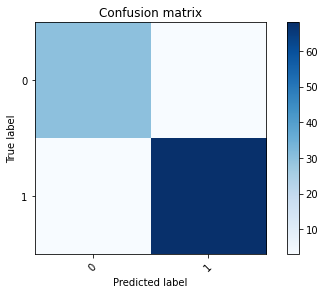

In [ ]:
print('Plotting confusion matrix')

outcome = encode_text_index(df, 'class')

plt.figure()
plot_confusion_matrix(cm_cnn, outcome)
plt.show()

In [ ]:
cnn_f1_4 = metrics.f1_score(cnn_y_true4, cnn_pred4, average='weighted')
print('\nAveraged F1: {}'.format(cnn_f1_4))

           
print(metrics.classification_report(cnn_y_true4, cnn_pred4))

cnn_score4 = metrics.accuracy_score(cnn_y_true4, cnn_pred4)
print('Accuracy: {}'.format(cnn_score4))


Averaged F1: 0.9423076923076923
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.96      0.96      0.96        71

    accuracy                           0.94       104
   macro avg       0.93      0.93      0.93       104
weighted avg       0.94      0.94      0.94       104

Accuracy: 0.9423076923076923


## Best Model Results for Fully Connected Neural Network Models (Model #2)

In [ ]:
cm_fcnn = metrics.confusion_matrix(y_true, pred2)
print("Confusion Matrix:\n")
print(cm_fcnn)

Confusion Matrix:

[[32  1]
 [ 1 70]]


Plotting confusion matrix


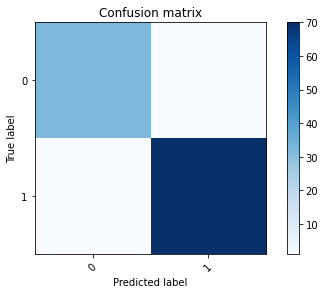

In [ ]:
print('Plotting confusion matrix')

outcome = encode_text_index(df, 'class')

plt.figure()
plot_confusion_matrix(cm_fcnn, outcome)
plt.show()

In [ ]:
score = metrics.accuracy_score(y_true, pred2)

print("Accuracy score: {}".format(score))

Accuracy score: 0.9807692307692307


In [ ]:
print(metrics.classification_report(y_true, pred2))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.99      0.99      0.99        71

    accuracy                           0.98       104
   macro avg       0.98      0.98      0.98       104
weighted avg       0.98      0.98      0.98       104



## Results

Having played around with both neural network model types and models using Random Forest, KNN, and SVM algorithms, we were able to successfully use AI to predict diabetes risk among patients using the dataset provided by the UCI Repository. The model using Random Forest was able to perform with the highest accuracy score of 99%. For our best fully connected neural network model, its accuracy score was 98% and the CNN model had 94%. In our evaluation of the performance of CNN vs. fully connected neural network models, we have determined that CNN models are the better predictor for classification between the two neural network model types. This is due to the fact that the performance of the fully connected neural network models was very inconsistent. The accuracy scores range from low 30%'s to high 60%'s with very few instances going above the upper range. On the other hand, the CNN models would consistently perform with accuracy scores sitting above 80% on all trial runs. Therefore, we consider our best fully connected neural network model to be an outlier and our CNN model to be the best predictor of the two.